In [61]:
#-----------------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

import sys

sys.path.insert(1, '/mnt/c/scripts/tools/')

from bigquery_bucket_tools import *
from plot_tools import *
from tools import *


import time as t
from datetime import datetime, timedelta, date 
from dateutil.relativedelta import *
from netCDF4 import Dataset   
import glob
import requests 
import pandas as pd
import xarray as xr
import requests 
import functools
import operator
import wget
import os
import gc
import numpy as np
import pygrib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
import datetime as dt
import holidays


import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import shapefile
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy, cartopy.crs as ccrs   
import regionmask
from shapely.geometry import Point, Polygon

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker 
import scipy.ndimage as ndimage
from PIL import Image
from scipy.ndimage import gaussian_filter
import scipy.ndimage

from google.cloud import storage, bigquery

Dado geral 
------------------
* Filtragem de pandemia e apagão

In [62]:
#Diretórios 

root='/mnt/c/scripts/Disp_carga_e_temp'

direc='/mnt/c/scripts/Disp_carga_e_temp'

carga = pd.read_parquet(f'{root}/carga.pq')

samet = pd.read_parquet(f'{root}/samet.pq')



dict_submarket = {'Nordeste':'NE', 
                'SUDESTE/CENTRO-OESTE':'SECO',
                'Sudeste':'SECO',
                'Norte':'N', 
                'Sul':'S',
                'NORDESTE':'NE', 
                'SUDESTE':'SECO',
                'NORTE':'N', 
                'SUL':'S',
                'SE/CO':'SECO'}



#Modifica os nomes das colunas para o merge, retirando programado e os outros tipos de carga 

carga = carga.query('tipo== "Carga"').rename({'data':'data','submercado':'submarket'},axis=1).drop(['programado','tipo'],axis=1).reset_index(drop=True)

carga['submarket']= carga['submarket'].replace(to_replace =dict_submarket) 


carga.sort_values(by=['data','submarket'])


samet_1 = samet.rename({'date_ref': 'data'},axis =1)


df = carga.merge(samet_1, on=['data','submarket']).sort_values(by=['data','submarket']).reset_index(drop=True)


df['data'] = pd.to_datetime(df['data'])

#Filtragem apagão e pandemia 
df_f = df.drop(df.query('(data > "2001-05-01" and data < "2002-12-01") or (data > "2020-03-01" and data < "2020-10-01")').index).sort_values('data')

df_f.data.dt.weekday.drop_duplicates()

# df_f['day_of_year']= df_f['data'].dt.day_of_year #agrupa dias a cada ano 


0     5
4     6
8     0
15    1
16    2
20    3
27    4
Name: data, dtype: int64

Daily Trend
--------------------

In [63]:

df_f['semana']= df_f['data'].dt.dayofweek


# ----MUDAR O SUBMERCADO---------------------
SUB = df_f.query('submarket == "N"')

#carga média por todos os dias do ano
pm_y = SUB.groupby(SUB.data.dt.year).agg({'verificado': np.average}) 


# consumo médio de energia do cada dia da semana correspondente a cada ano
pm_yj = SUB.groupby([SUB.semana, SUB.data.dt.year])['verificado'].mean()



df1 = pm_yj.to_frame().reset_index()

df2= pm_y.reset_index()

df_merge = df1.merge(df2,on='data')

df_merge = df_merge.rename({'verificado_x':'pm_yj','verificado_y':'pm_y','data':'year'},axis=1)


**Alpha_j**


responsável pelos padrões normais dos dias dentro do
semana (0 a 6)


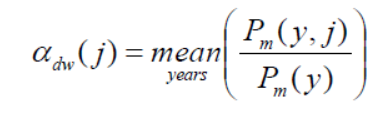

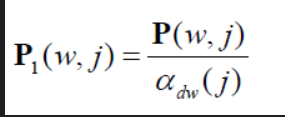

In [64]:
#Retira a tendência semanal 

df_merge['div'] = df_merge.pm_yj / df_merge.pm_y

alpha = df_merge.groupby('semana')['div'].mean()

df_r = SUB.merge(alpha, on=['semana']).sort_values(by=['data','semana']).reset_index(drop=True)

df_r = df_r.rename({'div':'alpha_j'},axis=1)

df_r['data'] = pd.to_datetime(df_r['data'])


#Série sem tendência 
df_r['P1'] = df_r['verificado'] / df_r['alpha_j']


Separando Dias úiteis, finais de semana e feriados 

In [65]:
feriados= holidays.Brazil()

list_feriado = []
    
for feriado in feriados['2000-01-01': '2023-04-03'] :
    list_feriado.append(feriado)

df_r.reset_index().sort_index()

clas_day = df_r['data'].isin(list_feriado) #chega se existem valores pespecificos, sendo sendo False e True

df_r['holy'] = clas_day


def converter_para_booleano(valor):
    if valor != 5 and valor != 6:
        return True
    else:
        return False
    
df_r['dia_util'] = df_r['semana'].apply(converter_para_booleano)

df = df_r.copy()

**Classes** 

* A - dia útil antes do dia não útil
* B - dia útil após o dia não útil
* C - dia útil entre dois dias não úteis
* D - dias úteis
* E - dias não úteis

In [66]:
def classificar_entre_linhas(df, coluna_dias_util, coluna_holy, coluna_classe):
    
    df[coluna_classe] = 'Não Classificado'  # padrão
    
    for i in range(1, len(df) - 1):

          #Dia anterior  
          dia_anterior = df.loc[i - 1, coluna_dias_util]
          holy_anterior = df.loc[i - 1, coluna_holy]

          #Dia posterior  
          dia_posterior = df.loc[i + 1, coluna_dias_util]
          holy_posterior = df.loc[i + 1, coluna_holy]
          
          #Dia atual    
          dia_atual = df.loc[i, coluna_dias_util]
          holy_atual = df.loc[i, coluna_holy]


     # CLASSE E

          if (dia_atual == False or holy_atual == True):
               df.loc[i, coluna_classe] = 'E'
          
     # CLASSE C 

          elif  (dia_anterior == False or holy_anterior == True) and (dia_atual==True and holy_atual==False) and (dia_posterior == False or holy_posterior == True):
               df.loc[i, coluna_classe] = 'C'   


     # CLASSE A 
          elif (dia_atual == True or holy_atual ==False) and dia_posterior == False:
               df.loc[i, coluna_classe] = 'A'   


     #  CLASSE B 
          elif (dia_anterior == False or holy_anterior ==True) and dia_atual == True:
               df.loc[i, coluna_classe] = 'B'    
          
                    
     # CLASSE D
          elif (dia_atual == True or holy_atual == False):
               df.loc[i, coluna_classe] = 'D'

    
    return df


df = classificar_entre_linhas(df_r, 'dia_util', 'holy', 'classe')



df.loc[0, 'classe'] = df.loc[0, 'classe'].replace('Não Classificado', 'E') 
df.loc[7702, 'classe'] = df.loc[7702, 'classe'].replace('Não Classificado', 'D') 

df.classe.unique()



# df.head(30)

# display(df.isnull().any())


array(['E', 'B', 'D', 'A', 'C'], dtype=object)

**Alpha_t**


responsável pelos padrões normais das classes

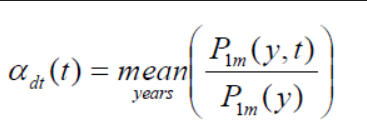

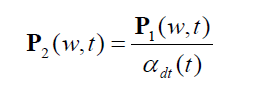

In [67]:
#Fazer a média de P1_wj para cada classe (a,b...) e semana (0,1.....,6) -P1m(y)
P1_my = df.P1.groupby([df.data.dt.year]).mean()
P1_my.to_frame().reset_index('data')


# #P1_yt --> consumo médio de energia correspondente a classe por ano 
P1_yt = df.groupby([df.classe, df.data.dt.year])['P1'].mean()


df1 = P1_my.to_frame().reset_index()
df2= P1_yt.reset_index()


df_merge = df1.merge(df2,on=['data'])
df_merge = df_merge.rename({'P1_x':'P1_my','P1_y':'P1','data':'year'},axis=1)


df_merge['div'] = df_merge.P1 / df_merge.P1_my

alpha_t = df_merge.groupby('classe')['div'].mean()

df_fim = df.merge(alpha_t, on=['classe']).sort_values(by=['data']).reset_index(drop=True)

df_fim = df_fim.rename({'div':'alpha_t'},axis=1)

#Série sem tendência 
df_fim['P2'] = df_fim.P1 / df_fim.alpha_t

# df_fim.alpha_t.describe()

Seasonal trend

In [68]:
df_fim['day_of_year']= df_fim['data'].dt.day_of_year #agruda dias a cada ano 


#P3m(y) is the power for dayofyear   of yth year
p3m_y = df_fim.groupby([df_fim.day_of_year, df_fim.data.dt.year])['P2'].mean()

# # Pm(y) --> carga média por todos os dias do ano
pm_y = df_fim.groupby(df_fim.data.dt.year).agg({'P2': np.average}) 




df1 = p3m_y.to_frame().reset_index()

df2= pm_y.reset_index()

df_merge_sesonal = df1.merge(df2,on='data')

df_merge_sesonal = df_merge_sesonal.rename({'P2_x':'p3m_y','P2_y':'pm_y','data':'year'},axis=1)

# df_merge_sesonal

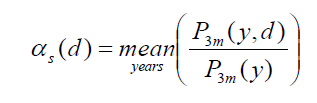

In [69]:
df_merge_sesonal['div'] = df_merge_sesonal.p3m_y / df_merge_sesonal.pm_y

alpha_d = df_merge_sesonal.groupby([df_merge_sesonal.day_of_year])['div'].mean()




df_detrend = df_fim.merge(alpha_d, on=['day_of_year']).sort_values(by=['day_of_year']).reset_index(drop=True)

df_detrend = df_detrend.rename({'div':'alpha_d'},axis=1)

#Série sem tendência
df_detrend['P3'] = df_detrend.P2 / df_detrend.alpha_d

In [70]:
df_detrend

,data,submarket,verificado,mean_temperature,mean_temperature_pop,mean_temperature_ons,semana,alpha_j,P1,holy,dia_util,classe,alpha_t,P2,day_of_year,alpha_d,P3
0,2000-01-01,N,2243.512500,25.606749,26.199050,26.537545,5,0.982190,2284.193960,True,False,E,0.994032,2297.908916,1,0.893453,2571.941187
1,2023-01-01,N,5705.000000,26.178668,26.418584,26.966196,6,0.941849,6057.233093,True,False,E,0.994032,6093.602459,1,0.893453,6820.282141
2,2022-01-01,N,5037.000000,25.263384,25.394483,25.518990,5,0.982190,5128.335578,True,False,E,0.994032,5159.127577,1,0.893453,5774.368432
3,2021-01-01,N,5245.000000,26.635997,26.477635,26.876111,4,1.015655,5164.157565,True,True,E,0.994032,5195.164649,1,0.893453,5814.703029
4,2020-01-01,N,4846.000000,26.035530,25.932926,26.598899,2,1.017164,4764.229073,True,True,E,0.994032,4792.834871,1,0.893453,5364.394264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7698,2000-12-31,N,2457.320833,26.640018,27.094343,27.807565,6,0.941849,2609.038575,False,False,E,0.994032,2624.703992,366,0.971110,2702.788589
7699,2004-12-31,N,2952.445833,27.294593,27.506164,28.212062,4,1.015655,2906.939082,False,True,A,1.003550,2896.657128,366,0.971110,2982.832296
7700,2008-12-31,N,3501.800417,27.326884,27.559797,28.369888,2,1.017164,3442.711381,False,True,D,1.003261,3431.522144,366,0.971110,3533.609476
7701,2012-12-31,N,3717.348333,26.816178,26.703569,28.553564,0,1.010285,3679.504746,False,True,C,0.967373,3803.603922,366,0.971110,3916.760638


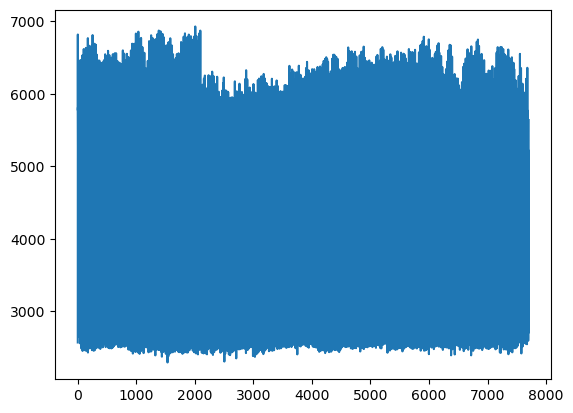

In [71]:
plt.plot(df_detrend['P3'])

In [72]:
# plt = sns.scatterplot(data=df_detrend, x="mean_temperature", y="verificado",hue='submarket', palette="deep")
# save = plt.get_figure()
# save.savefig('verificado_N.png',dpi=250)

In [73]:
# plt = sns.scatterplot(data=df_detrend, x="mean_temperature", y="P3",hue='submarket', palette="dark")
# save = plt.get_figure()
# save.savefig('N_SEM_TEND.png',dpi=250)

In [74]:
#------SALVA OS DADOS EM CSV

# df_detrend.to_csv('arquivos/SECO_detrend.csv', index=False)